In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from torch.nn.utils import prune

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

# data setting


In [3]:
from sklearn.preprocessing import RobustScaler 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [5]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
x_in = torch.Tensor(X_train.values).to(device).to(torch.float32)
x_val = torch.Tensor(X_test.values).to(device).to(torch.float32)

y_in = torch.Tensor(y_train.values).to(device).to(torch.float32)
y_val = torch.Tensor(y_test.values).to(device).to(torch.float32)

scaler = RobustScaler()
y_train_s = scaler.fit_transform(y_train.array.reshape(-1, 1))
y_in_s = torch.Tensor(y_train_s).to(device).to(torch.float32)
y_test_s = scaler.transform(y_test.array.reshape(-1, 1))
y_val_s = torch.Tensor(y_test_s).to(device).to(torch.float32)


In [8]:
#Xavier initialization
def init_weights(m, k=1, gain=10):
    for i in m:
        if isinstance(i, nn.Linear):
            nn.init.xavier_normal_(i.weight, gain=gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()
#set DO and BN layer
def DO_BN(model,DO:bool,BN:bool):
    dropout_probs = [ 0.1,0.1,0.1]
    for name, module in model.named_modules():
        if isinstance(module, nn.Dropout):
            module.p =  dropout_probs.pop(0) if DO else 0
        if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
            module.track_running_stats = BN

def forward(model,x = x_in,y = y_in_s,l2=False):
    y_pred = model(x)
    loss = nn.functional.mse_loss(y_pred,y).to(device)
    if l2:
        loss+=  l2_loss(model)
    return loss
    






In [9]:
#trian process
def training(model,EB = True, LG = False,UA= False, DO = False, BN = False, l2 = True,
             regulization = True,initial_lr = 1e-3, stopping_lr = 6e-5, stopping_error = 0.05 , stopping_epochs = 75):
    #set old model to output_model when running regulization
    if regulization:
        output_model = model
    else:
        init_weights(model,0.1,1)
        print(1)
   #activate DO and BNlayer or not
    DO_BN(model,DO,BN)
    # Disable tracking running statistics
    if UA and DO: print("Warning: Some error may occur for DO+ReduceLROnPlateau scheduler. Consider changing to CosineAnnealingLR scheduler.")
    #set Adam to be optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    #set learning scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,verbose=True,
                                                              cooldown=10, min_lr=0, eps=1e-05)
    epochs = 0
    loss_in_list = []
    loss_out_list = []
    while True:
        #forward
        epochs += 1
        model.eval()# 切換到評估模式
        loss_out = forward(model,x_val,y_val_s,l2)

        model.train()  # 切換到訓練模式
        loss_in = forward(model,x_in,y_in_s,l2)
  
        #store loss values
        loss_in_list.append(loss_in.item())
        loss_out_list.append(loss_out.item())
        
        #check LG critiria
        if (loss_in < stopping_error) & LG:    
            print("LG stop")
            break      

        #backward
        optimizer.zero_grad()
        loss_in.backward()
        optimizer.step()
        #check UA critiria
        lr_scheduler.step(loss_in)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
        if  UA :
            for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1.02
            if (current_lr<stopping_lr) :
                print('UA stop')
                break
        if regulization:
            output_model = model
            print('update new model')                 

        #check EB critiria
        if (epochs >= stopping_epochs) & EB:
            print("EB stop")
            if regulization:
                if ~UA and ~LG and (loss_in < stopping_error):
                    output_model = model
                    print('new model accept')
                else:
                    print("unacceptable model")
            break


    print(f'Training finished in {epochs} epochs.')
    
    if regulization:
        return loss_in_list,loss_out_list,stopping_error, output_model
    return loss_in_list, loss_out_list, stopping_error


In [10]:
#plot errors
def draw_lr_step(loss_in_list,loss_out_list,stopping_error):
    # Assuming you have the epoch numbers as a list
    epoch_list = list(range(1, len(loss_in_list)+1))

    # Assuming you have the lists for loss_in and loss_out

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, loss_in_list, label='Loss In')
    plt.plot(epoch_list, loss_out_list, label='Loss Out')
    plt.axhline(y=stopping_error, color='gray', linestyle='--',
                linewidth=1.5, label='Stopping Value = '+str(stopping_error))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of LG weight tuning')
    plt.legend()
    plt.ylim(0, 1)
    plt.scatter(epoch_list[-1], loss_out_list[-1], color='red', s=100, label='Last Point out')
    plt.text(epoch_list[-1], loss_out_list[-1]+0.03, f'  {loss_out_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.scatter(epoch_list[-1], loss_in_list[-1], color='red', s=100, label='Last Point in')
    plt.text(epoch_list[-1], loss_in_list[-1]+0.03, f'  {loss_in_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.grid(True)
    plt.show()


In [11]:
def draw_pred_reggsion(model,print_error = True):
    model.eval()
    y_pred_val_s = model(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
    y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
    loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
    if print_error:
        print(torch.Tensor.cpu(loss1).tolist())
        print(torch.Tensor.cpu(loss2).tolist())
        

    y_pred_val_list = y_pred_val.tolist()
    y_val_list = y_val.tolist()
    # Perform linear regression
    slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
    plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
    plt.xlabel('Prediction')
    plt.ylabel('House Price')
    plt.title('Regression line between Prediction and House Price')
    plt.legend()
    plt.grid(True)
    plt.show()



In [43]:
a = [1,2,3]
a.pop()
a

[1, 2]

In [52]:
def mask_node(layer,i, unmask = False):
        mask = torch.ones(layer.weight.shape, device=layer.weight.device)
        if unmask:
                layer.register_buffer('weight_mask', mask )
        else:
                mask[:, i] = 0  
                prune.custom_from_mask(layer, name='weight', mask=mask)

def find_linear(model):
        linear_id = []
        for i,layer in enumerate(model.children()):
                if isinstance(layer, nn.Linear): linear_id.append(i)
        return  linear_id 

def prune_node_1(model ,tolerance = 0):
        origin_loss = forward(model)
        error_bound = origin_loss + tolerance
        linear_id = find_linear(model)
        linear_id.pop()
        for i in linear_id :
                #if i == len(model)-1: break
                layer = model[i]
                out_model = model
                for j in range(layer.weight.shape[0]):
                        mask_node(layer,j)
                        loss_new = forward(model)
                        print("Pruning layer",i,  "node",j ,", error_bound = ",round(error_bound .item(),4), "loss_new = ", round(loss_new.item(),4))
                        if loss_new  < error_bound:
                                prune.remove(layer, "weight")
                                out_model = model
                                print("node is removed")
                        else:
                                mask_node(layer,j,unmask = True)        
        
        print("Weight")
        print(layer .weight)
        print("buffers")
        print(list(layer .named_buffers()))
        print("named_parameters")
        print(list(layer .named_parameters()))
        return out_model
                                

def prune_node_2(model ,tolerance = 0.01):
        origin_loss = forward(model)
        error_bound = origin_loss + tolerance
        linear_id = find_linear(model)
        for i in linear_id :
                layer = model[i]
                if i != len(model)-1:
                        drops = []
                        out_model = model
                        for j in range(layer.weight.shape[0]):
                                mask_node(layer,j)
                                training(model, l2 = False,regulization = False,stopping_epochs = 75)
                                loss_new = forward(model)
                                print("Pruning layer",i,  "node",j ,", error_bound = ",round(error_bound .item(),4), "loss_new = ", round(loss_new.item(),4))
                                if loss_new  < error_bound:
                                        prune.remove(layer, "weight")
                                        out_model = model
                                        print("node is removed")
                                        drops.append(j)
                                else:
                                        mask_node(layer,j,unmask = True)
                        print(drops)    

        return out_model
        

In [53]:
'''#init_weights(model_11)
for i in model_11.children():
    if isinstance(i, nn.Linear):
        mask_node(i,1,unmask =False) 
        print("Weight")
        print(i.weight)
        print("buffers")
        print(list(i.named_buffers()))
        print("named_parameters")
        print(list(i.named_parameters()))
        #prune.remove(i, 'weight')


model_11.train()
print(forward(model_11,x_in,y_in_s))

model_11.eval()
print(forward(model_11,x_in,y_in_s))'''

'#init_weights(model_11)\nfor i in model_11.children():\n    if isinstance(i, nn.Linear):\n        mask_node(i,1,unmask =False) \n        print("Weight")\n        print(i.weight)\n        print("buffers")\n        print(list(i.named_buffers()))\n        print("named_parameters")\n        print(list(i.named_parameters()))\n        #prune.remove(i, \'weight\')\n\n\nmodel_11.train()\nprint(forward(model_11,x_in,y_in_s))\n\nmodel_11.eval()\nprint(forward(model_11,x_in,y_in_s))'

## Best Model: 11 hidden  with RELU act

N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, 50),
    nn.BatchNorm1d(50, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(50, 11),
    nn.BatchNorm1d(11, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(11, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [54]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

### 0.1 weight tuning EB  + pruning 1

In [55]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)

1
Epoch 1: Loss In 0.929885983467102, Loss Out 1.038158655166626, Learning Rate 0.001
Epoch 2: Loss In 0.8854994773864746, Loss Out 1.0142245292663574, Learning Rate 0.001
Epoch 3: Loss In 0.8557692170143127, Loss Out 1.0036629438400269, Learning Rate 0.001
Epoch 4: Loss In 0.8298416137695312, Loss Out 0.9942060708999634, Learning Rate 0.001
Epoch 5: Loss In 0.8055036664009094, Loss Out 0.9830570220947266, Learning Rate 0.001
Epoch 6: Loss In 0.784572422504425, Loss Out 0.9723791480064392, Learning Rate 0.001
Epoch 7: Loss In 0.7681184411048889, Loss Out 0.9639400839805603, Learning Rate 0.001
Epoch 8: Loss In 0.7554043531417847, Loss Out 0.9577429294586182, Learning Rate 0.001
Epoch 9: Loss In 0.7449931502342224, Loss Out 0.9528219103813171, Learning Rate 0.001
Epoch 10: Loss In 0.73565673828125, Loss Out 0.9488316178321838, Learning Rate 0.001
Epoch 11: Loss In 0.7269359827041626, Loss Out 0.9460088610649109, Learning Rate 0.001
Epoch 12: Loss In 0.71880042552948, Loss Out 0.94453775

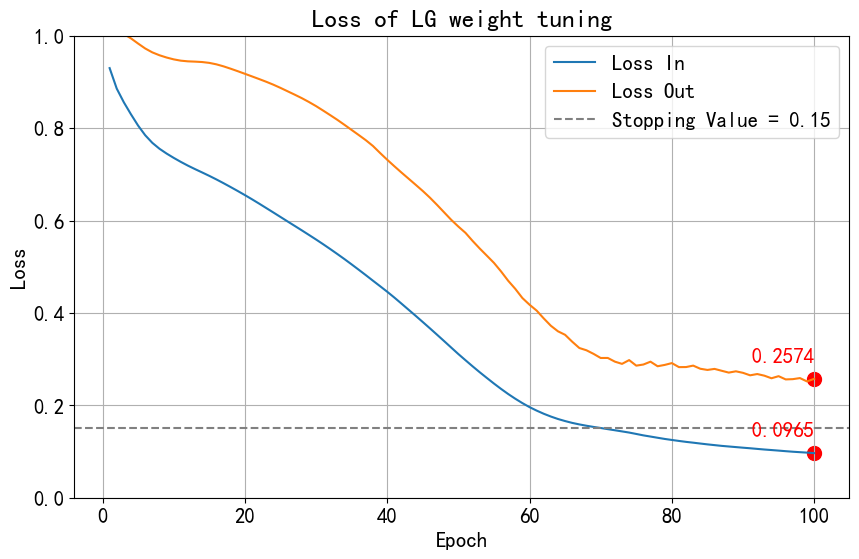

In [56]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2555883824825287
10506679296.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_32796\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


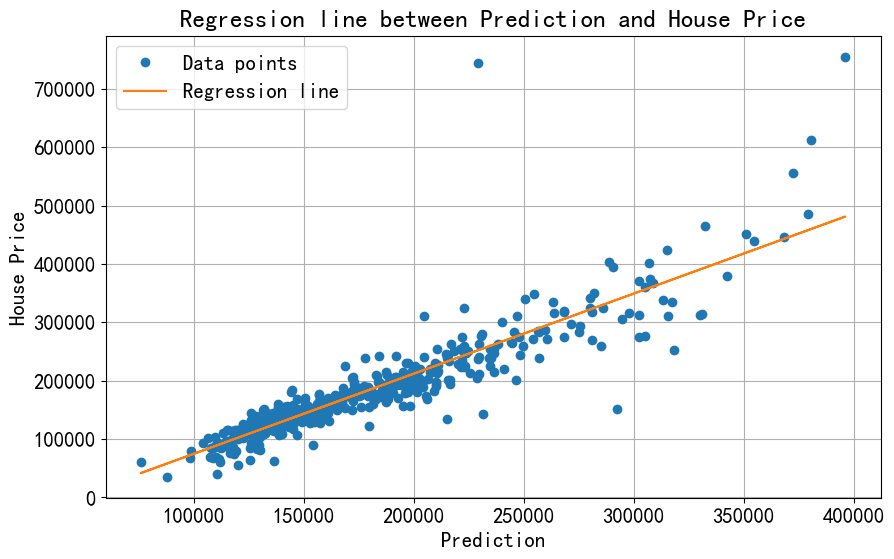

In [57]:
draw_pred_reggsion(model_11,print_error = True)

In [58]:
new_model = prune_node_1(model_11)

Pruning layer 0 node 0 , error_bound =  0.0955 loss_new =  0.0957
Pruning layer 0 node 1 , error_bound =  0.0955 loss_new =  0.0955
node is removed
Pruning layer 0 node 2 , error_bound =  0.0955 loss_new =  0.101
Pruning layer 0 node 3 , error_bound =  0.0955 loss_new =  0.0957
Pruning layer 0 node 4 , error_bound =  0.0955 loss_new =  0.0958
Pruning layer 0 node 5 , error_bound =  0.0955 loss_new =  0.0958
Pruning layer 0 node 6 , error_bound =  0.0955 loss_new =  0.0996
Pruning layer 0 node 7 , error_bound =  0.0955 loss_new =  0.0986
Pruning layer 0 node 8 , error_bound =  0.0955 loss_new =  0.0956
Pruning layer 0 node 9 , error_bound =  0.0955 loss_new =  0.0966
Pruning layer 0 node 10 , error_bound =  0.0955 loss_new =  0.0966
Pruning layer 0 node 11 , error_bound =  0.0955 loss_new =  0.0973
Pruning layer 0 node 12 , error_bound =  0.0955 loss_new =  0.0955
node is removed
Pruning layer 0 node 13 , error_bound =  0.0955 loss_new =  0.0996
Pruning layer 0 node 14 , error_bound =  

Sequential(
  (0): Linear(in_features=214, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0, inplace=False)
  (4): Linear(in_features=100, out_features=1, bias=True)
)

### 0.2 weight tuning EB  + pruning 2

In [295]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [296]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)

1
Epoch 1: Loss In 1.2596707344055176, Loss Out 1.3313202857971191, Learning Rate 0.001
Epoch 2: Loss In 1.1726453304290771, Loss Out 1.2615909576416016, Learning Rate 0.001
Epoch 3: Loss In 1.0977551937103271, Loss Out 1.2035754919052124, Learning Rate 0.001
Epoch 4: Loss In 1.0309312343597412, Loss Out 1.1536120176315308, Learning Rate 0.001
Epoch 5: Loss In 0.970751166343689, Loss Out 1.1105152368545532, Learning Rate 0.001
Epoch 6: Loss In 0.9173818826675415, Loss Out 1.0739493370056152, Learning Rate 0.001
Epoch 7: Loss In 0.8707212209701538, Loss Out 1.043405294418335, Learning Rate 0.001
Epoch 8: Loss In 0.830540120601654, Loss Out 1.0183210372924805, Learning Rate 0.001
Epoch 9: Loss In 0.7963287830352783, Loss Out 0.9977483153343201, Learning Rate 0.001
Epoch 10: Loss In 0.7676126956939697, Loss Out 0.9813420176506042, Learning Rate 0.001
Epoch 11: Loss In 0.7439139485359192, Loss Out 0.9688171744346619, Learning Rate 0.001
Epoch 12: Loss In 0.7249318957328796, Loss Out 0.9596

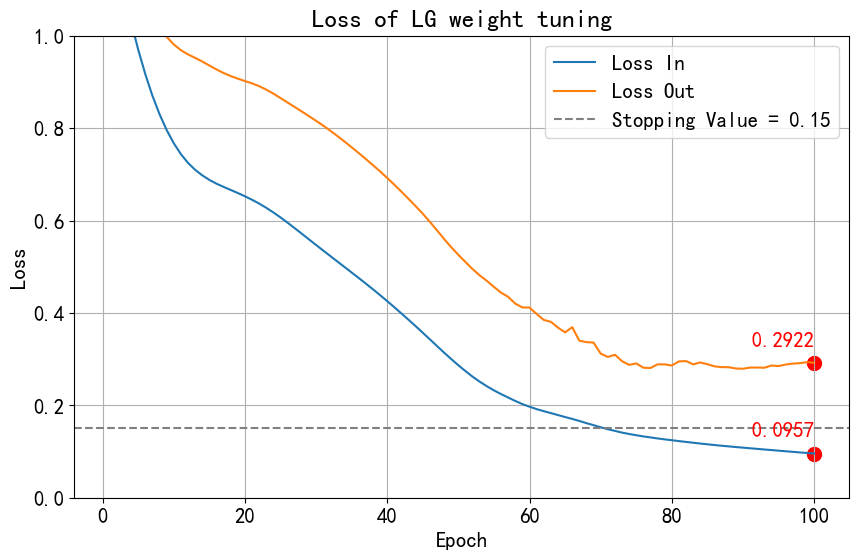

In [297]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2946067750453949
11049707520.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_33068\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


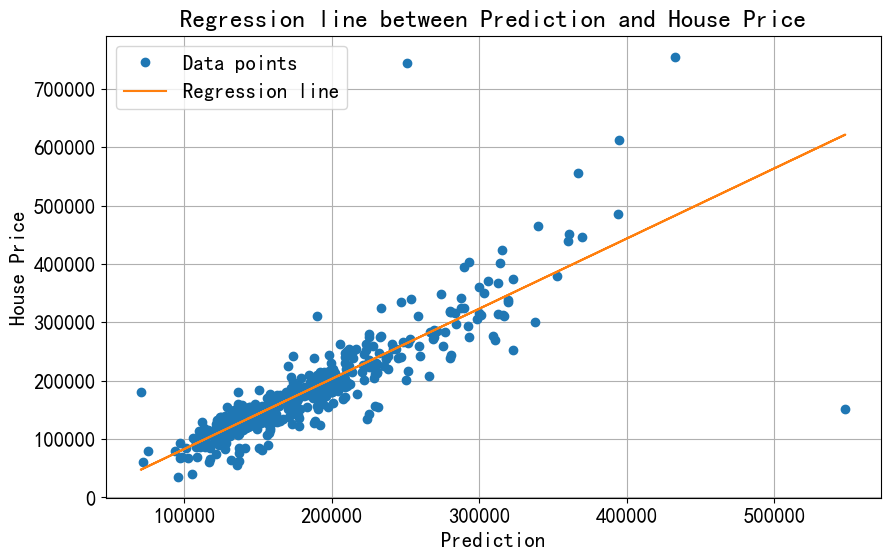

In [298]:
draw_pred_reggsion(model_11,print_error = True)

In [299]:
prune_node_2(model_11)

1
Epoch 1: Loss In 2.427417755126953, Loss Out 2.30898118019104, Learning Rate 0.001
Epoch 2: Loss In 1.999610185623169, Loss Out 1.8368761539459229, Learning Rate 0.001
Epoch 3: Loss In 1.6817083358764648, Loss Out 1.563871145248413, Learning Rate 0.001
Epoch 4: Loss In 1.4424337148666382, Loss Out 1.397194743156433, Learning Rate 0.001
Epoch 5: Loss In 1.256413459777832, Loss Out 1.2717673778533936, Learning Rate 0.001
Epoch 6: Loss In 1.1066073179244995, Loss Out 1.179362416267395, Learning Rate 0.001
Epoch 7: Loss In 0.9848576784133911, Loss Out 1.1053882837295532, Learning Rate 0.001
Epoch 8: Loss In 0.8848799467086792, Loss Out 1.0461251735687256, Learning Rate 0.001
Epoch 9: Loss In 0.8003785610198975, Loss Out 0.9974132180213928, Learning Rate 0.001
Epoch 10: Loss In 0.7272640466690063, Loss Out 0.9550278782844543, Learning Rate 0.001
Epoch 11: Loss In 0.6620157361030579, Loss Out 0.915111243724823, Learning Rate 0.001
Epoch 12: Loss In 0.6026566028594971, Loss Out 0.8722967505

### 1. weight tuning EB  + regularizing_EB with l2  loss 

#### train with EB

In [193]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 200

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)



1
Epoch 1: Loss In 1.8116519451141357, Loss Out 1.9406987428665161, Learning Rate 0.001
Epoch 2: Loss In 1.6381860971450806, Loss Out 1.7905691862106323, Learning Rate 0.001
Epoch 3: Loss In 1.4885741472244263, Loss Out 1.6660276651382446, Learning Rate 0.001
Epoch 4: Loss In 1.3584226369857788, Loss Out 1.5615339279174805, Learning Rate 0.001
Epoch 5: Loss In 1.2459222078323364, Loss Out 1.4753527641296387, Learning Rate 0.001
Epoch 6: Loss In 1.1488943099975586, Loss Out 1.4040988683700562, Learning Rate 0.001
Epoch 7: Loss In 1.0654324293136597, Loss Out 1.344665765762329, Learning Rate 0.001
Epoch 8: Loss In 0.9941428899765015, Loss Out 1.294636845588684, Learning Rate 0.001
Epoch 9: Loss In 0.9339551329612732, Loss Out 1.252285122871399, Learning Rate 0.001
Epoch 10: Loss In 0.8839607834815979, Loss Out 1.2161955833435059, Learning Rate 0.001
Epoch 11: Loss In 0.8431823253631592, Loss Out 1.1856069564819336, Learning Rate 0.001
Epoch 12: Loss In 0.8105829358100891, Loss Out 1.1600

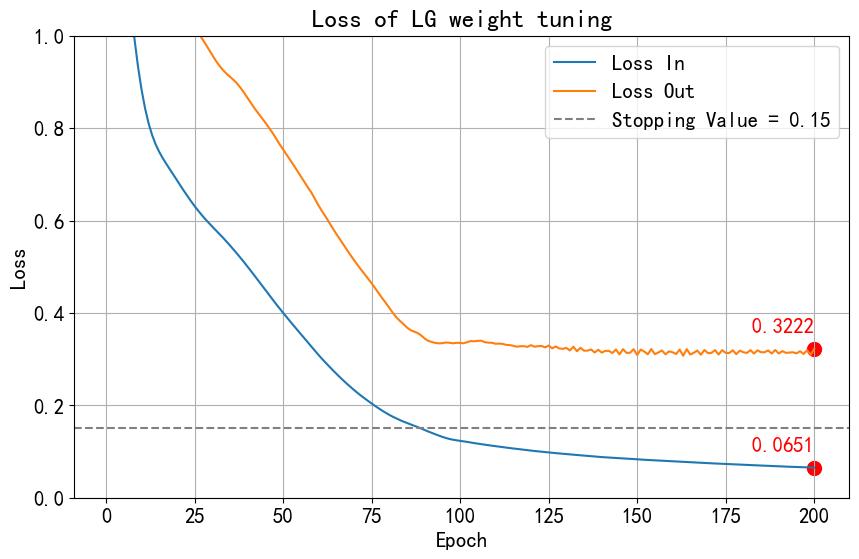

In [198]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2504953444004059
10930652160.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_33068\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


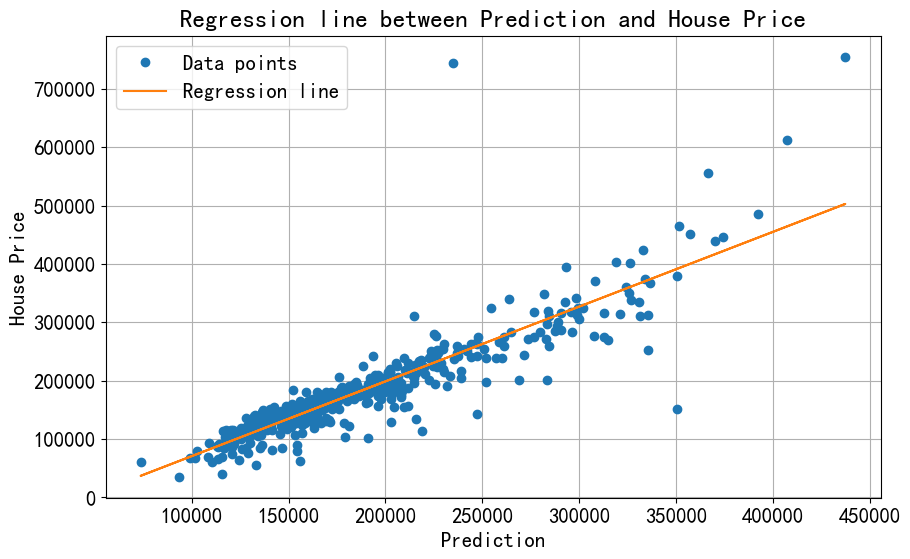

In [199]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB l2

In [203]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-1
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_regulization.append(model_11)

Epoch 1: Loss In 0.30530762672424316, Loss Out 0.6165698766708374, Learning Rate 0.1
update new model
Epoch 2: Loss In 26.020366668701172, Loss Out 24.705516815185547, Learning Rate 0.1
update new model
Epoch 3: Loss In 2.169240951538086, Loss Out 2.8003149032592773, Learning Rate 0.1
update new model
Epoch 4: Loss In 4.292140483856201, Loss Out 3.695906162261963, Learning Rate 0.1
update new model
Epoch 5: Loss In 8.232933044433594, Loss Out 7.607024192810059, Learning Rate 0.1
update new model
Epoch 6: Loss In 6.911642551422119, Loss Out 6.880134105682373, Learning Rate 0.1
update new model
Epoch 7: Loss In 3.9094960689544678, Loss Out 4.2050299644470215, Learning Rate 0.1
update new model
Epoch 8: Loss In 1.5700247287750244, Loss Out 1.8530824184417725, Learning Rate 0.1
update new model
Epoch 9: Loss In 0.9012241363525391, Loss Out 1.3123867511749268, Learning Rate 0.1
update new model
Epoch 10: Loss In 1.4153937101364136, Loss Out 1.9226298332214355, Learning Rate 0.1
update new m

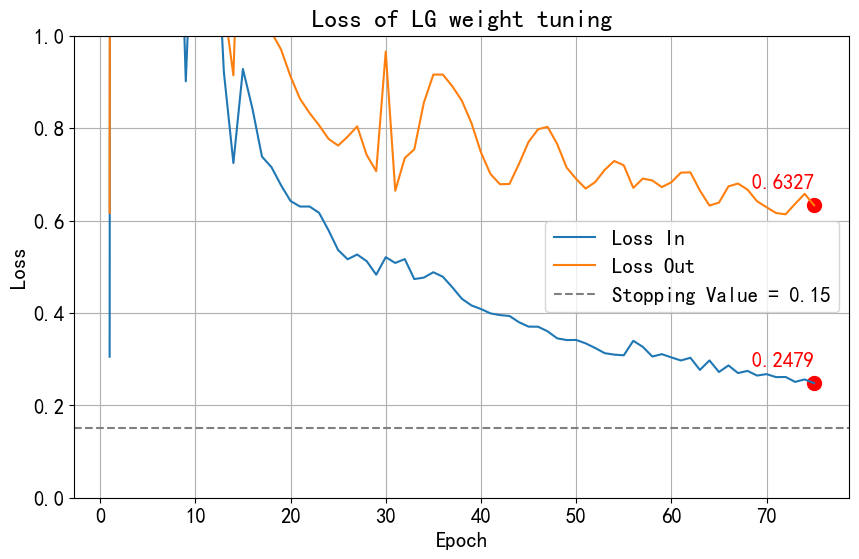

In [204]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.4635203778743744
9958668288.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_33068\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


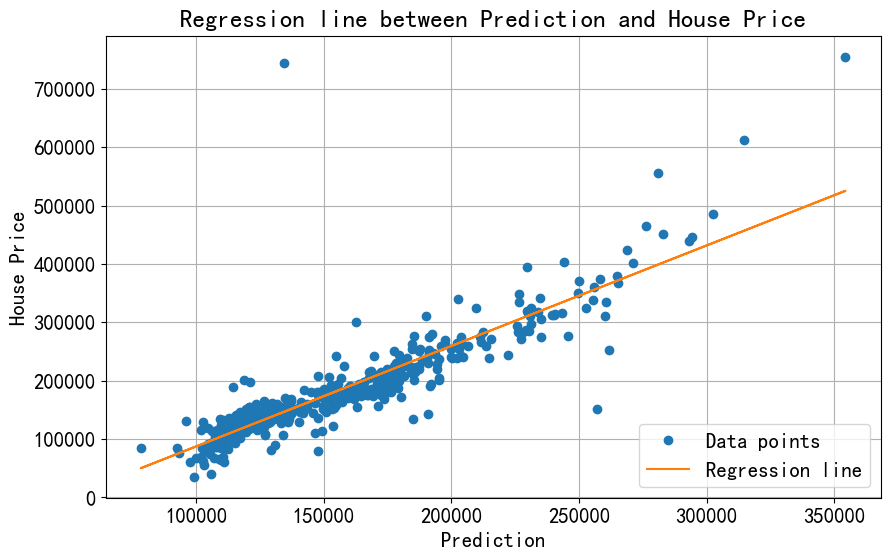

In [205]:
draw_pred_reggsion(model_11,print_error = True)

### 2. weight tuning LG UA  + regularizing_LG UA with l2  loss 

In [45]:
models_LGUA_accept = []
models_LGUA_regulization = []

#### train with LG UA

In [65]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.2 if l2 else 0.075
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_accept.append(model_11)



1
Epoch 1: Loss In 1.1757738590240479, Loss Out 1.169812798500061, Learning Rate 0.001
Epoch 2: Loss In 1.1459251642227173, Loss Out 1.1515637636184692, Learning Rate 0.00102
Epoch 3: Loss In 1.1164331436157227, Loss Out 1.1337817907333374, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 1.0872023105621338, Loss Out 1.1169768571853638, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 1.057932734489441, Loss Out 1.1003533601760864, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 1.028910756111145, Loss Out 1.0844435691833496, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 1.0002996921539307, Loss Out 1.069342851638794, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 0.9722021222114563, Loss Out 1.0550321340560913, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 0.9448265433311462, Loss Out 1.0415745973587036, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 0.9183592796325684, Loss Out 1.0289586782455444, Learning Rate 0.0011950925686223112
Epoch 11: L

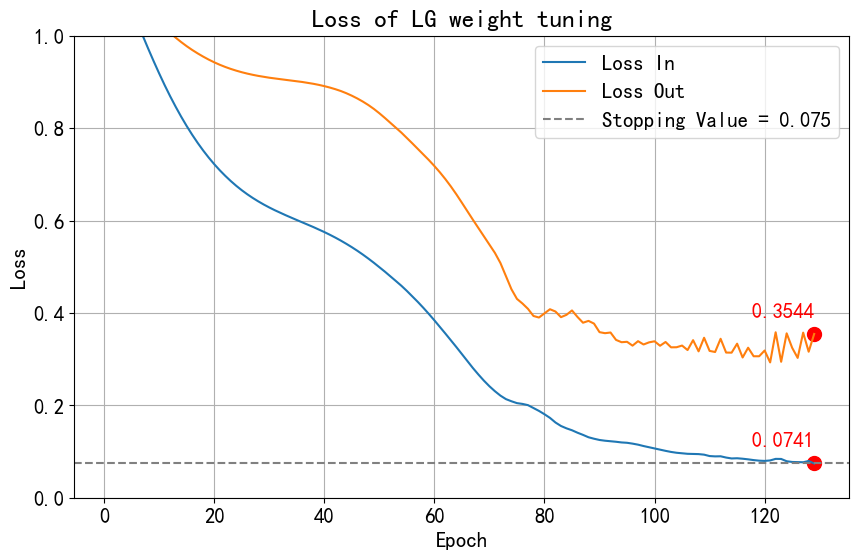

In [66]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.35443225502967834
10233542656.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


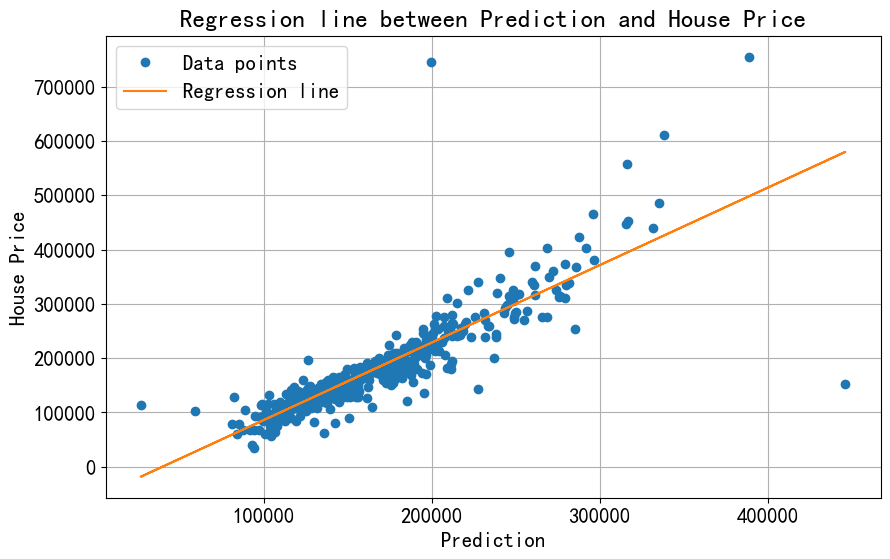

In [67]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with LG UA l2

In [68]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_regulization.append(model_11)

Epoch 1: Loss In 0.2498188018798828, Loss Out 0.5301651954650879, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.24658063054084778, Loss Out 0.4996389150619507, Learning Rate 0.00102
update new model
Epoch 3: Loss In 0.2461213320493698, Loss Out 0.4829653203487396, Learning Rate 0.0010404000000000001
update new model
Epoch 4: Loss In 0.24446812272071838, Loss Out 0.4797724187374115, Learning Rate 0.0010612080000000001
update new model
Epoch 5: Loss In 0.24268576502799988, Loss Out 0.48434367775917053, Learning Rate 0.0010824321600000002
update new model
Epoch 6: Loss In 0.24144169688224792, Loss Out 0.4934988021850586, Learning Rate 0.0011040808032000001
update new model
Epoch 7: Loss In 0.24041616916656494, Loss Out 0.5006582736968994, Learning Rate 0.0011261624192640003
update new model
Epoch 8: Loss In 0.23911555111408234, Loss Out 0.5006821155548096, Learning Rate 0.0011486856676492802
update new model
Epoch 9: Loss In 0.23775555193424225, Loss Out 0.4941466450691223, Lear

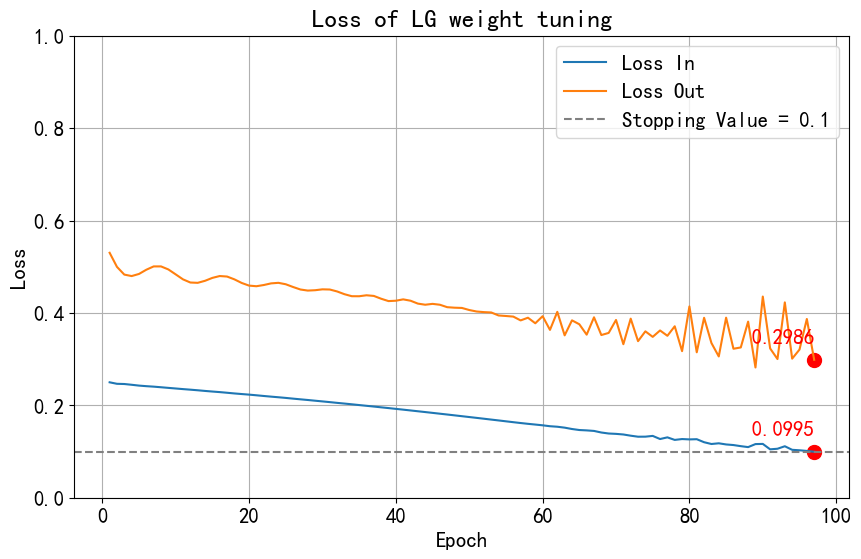

In [69]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2510243058204651
11435991040.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


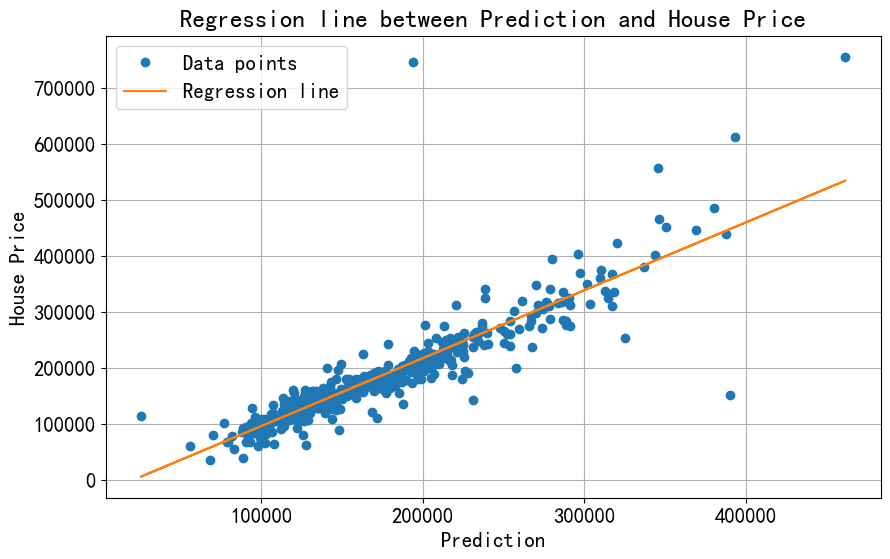

In [70]:
draw_pred_reggsion(model_11,print_error = True)

### 3. weight tuning EB LG UA  + regularizing EB LG UA  with l2  loss 

In [71]:
models_EBLGUA_accept = []
models_EBLGUA_regulization = []

#### train with EB LG UA 

In [72]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.05
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_accept.append(model_11)



1
Epoch 1: Loss In 1.4276401996612549, Loss Out 1.5052865743637085, Learning Rate 0.001
Epoch 2: Loss In 1.3880255222320557, Loss Out 1.4694892168045044, Learning Rate 0.00102
Epoch 3: Loss In 1.349015235900879, Loss Out 1.4350416660308838, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 1.3108339309692383, Loss Out 1.402029037475586, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 1.2734557390213013, Loss Out 1.3703547716140747, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 1.236990213394165, Loss Out 1.3399379253387451, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 1.2015693187713623, Loss Out 1.3108532428741455, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 1.1672649383544922, Loss Out 1.283155083656311, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 1.13417649269104, Loss Out 1.2568448781967163, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 1.102420449256897, Loss Out 1.2319341897964478, Learning Rate 0.0011950925686223112
Epoch 11: Loss

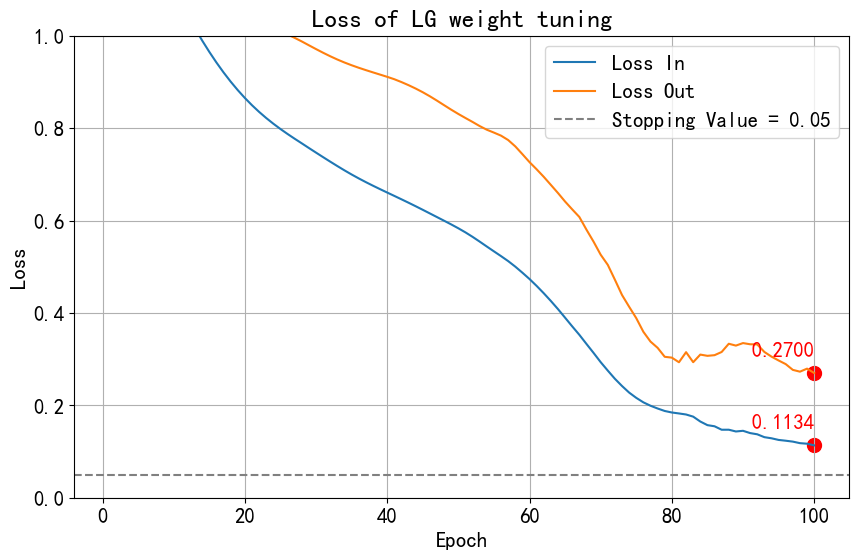

In [73]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2674473524093628
10814138368.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


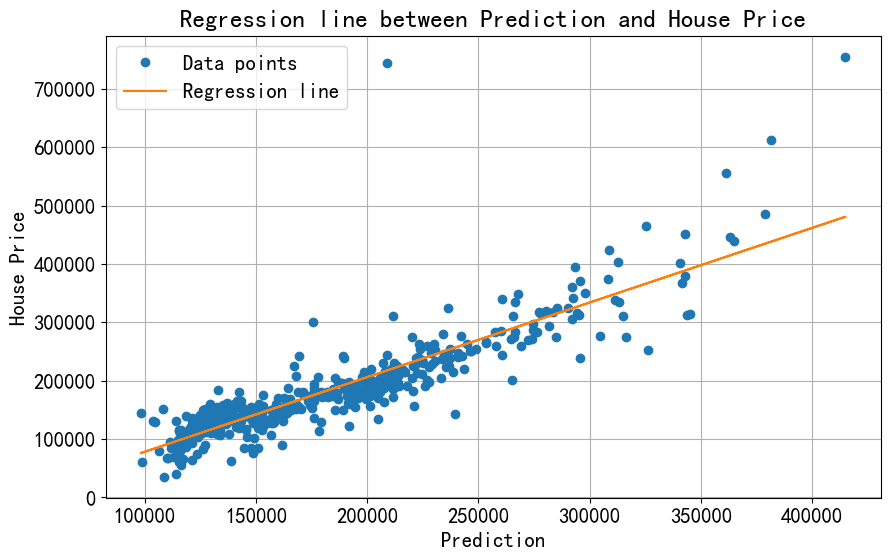

In [74]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB LG UA l2

In [75]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_regulization.append(model_11)

Epoch 1: Loss In 0.21635320782661438, Loss Out 0.37264007329940796, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.2165393829345703, Loss Out 0.3843781054019928, Learning Rate 0.00102
update new model
Epoch 3: Loss In 0.21249651908874512, Loss Out 0.37800854444503784, Learning Rate 0.0010404000000000001
update new model
Epoch 4: Loss In 0.21078169345855713, Loss Out 0.3741706311702728, Learning Rate 0.0010612080000000001
update new model
Epoch 5: Loss In 0.21039852499961853, Loss Out 0.37451744079589844, Learning Rate 0.0010824321600000002
update new model
Epoch 6: Loss In 0.20837685465812683, Loss Out 0.37400656938552856, Learning Rate 0.0011040808032000001
update new model
Epoch 7: Loss In 0.20596259832382202, Loss Out 0.3739142417907715, Learning Rate 0.0011261624192640003
update new model
Epoch 8: Loss In 0.20449954271316528, Loss Out 0.3752441704273224, Learning Rate 0.0011486856676492802
update new model
Epoch 9: Loss In 0.2033511996269226, Loss Out 0.3753679096698761, L

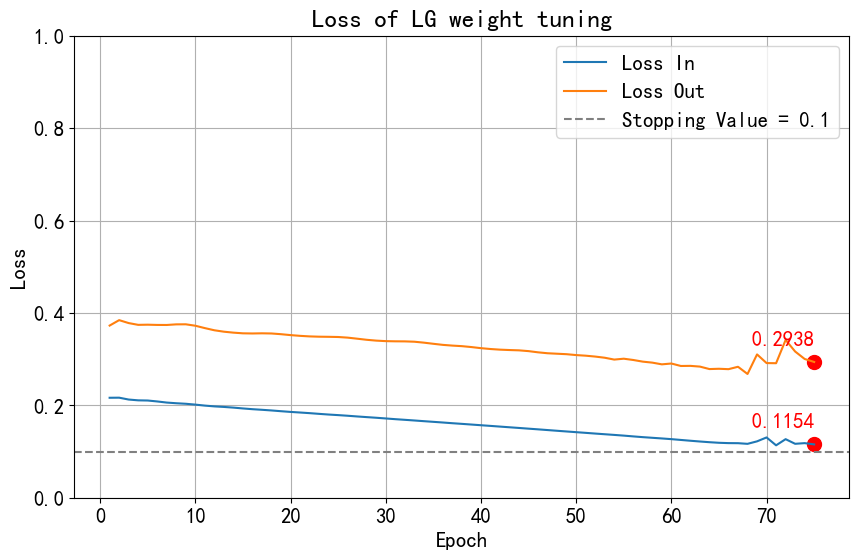

In [76]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.25985798239707947
10604532736.0


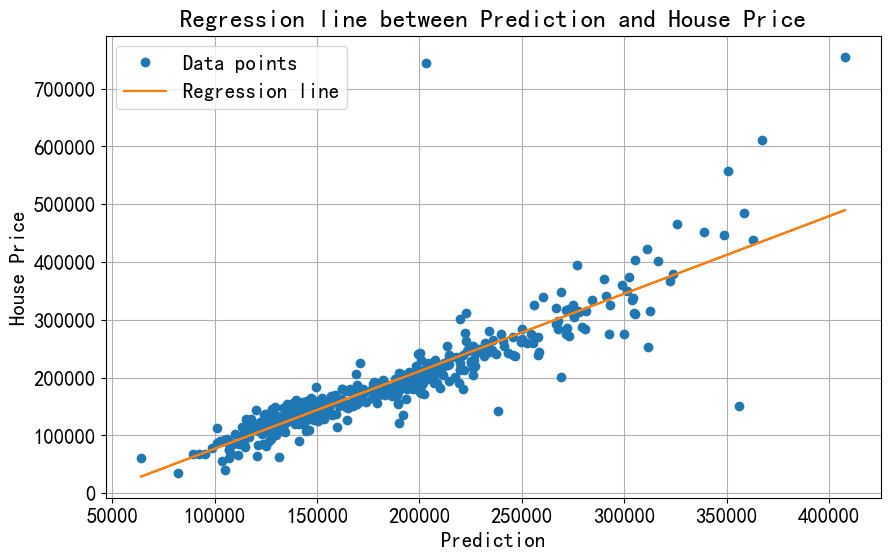

In [77]:
draw_pred_reggsion(model_11,print_error = True)

### 4. weight tuning EB   + regularizing EB DO

In [78]:
models_EBDO_accept = []
models_EBDO_regulization = []

#### train with EB 

In [79]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_accept.append(model_11)



1
Epoch 1: Loss In 1.3907244205474854, Loss Out 1.4293617010116577, Learning Rate 0.001
Epoch 2: Loss In 1.3625952005386353, Loss Out 1.40305495262146, Learning Rate 0.001
Epoch 3: Loss In 1.3354096412658691, Loss Out 1.3782461881637573, Learning Rate 0.001
Epoch 4: Loss In 1.309281826019287, Loss Out 1.354809045791626, Learning Rate 0.001
Epoch 5: Loss In 1.2841562032699585, Loss Out 1.332709550857544, Learning Rate 0.001
Epoch 6: Loss In 1.2600773572921753, Loss Out 1.3119499683380127, Learning Rate 0.001
Epoch 7: Loss In 1.2368147373199463, Loss Out 1.2923901081085205, Learning Rate 0.001
Epoch 8: Loss In 1.214375615119934, Loss Out 1.2739388942718506, Learning Rate 0.001
Epoch 9: Loss In 1.1927741765975952, Loss Out 1.2565149068832397, Learning Rate 0.001
Epoch 10: Loss In 1.1719496250152588, Loss Out 1.2400530576705933, Learning Rate 0.001
Epoch 11: Loss In 1.151780128479004, Loss Out 1.2244939804077148, Learning Rate 0.001
Epoch 12: Loss In 1.1322638988494873, Loss Out 1.20976662

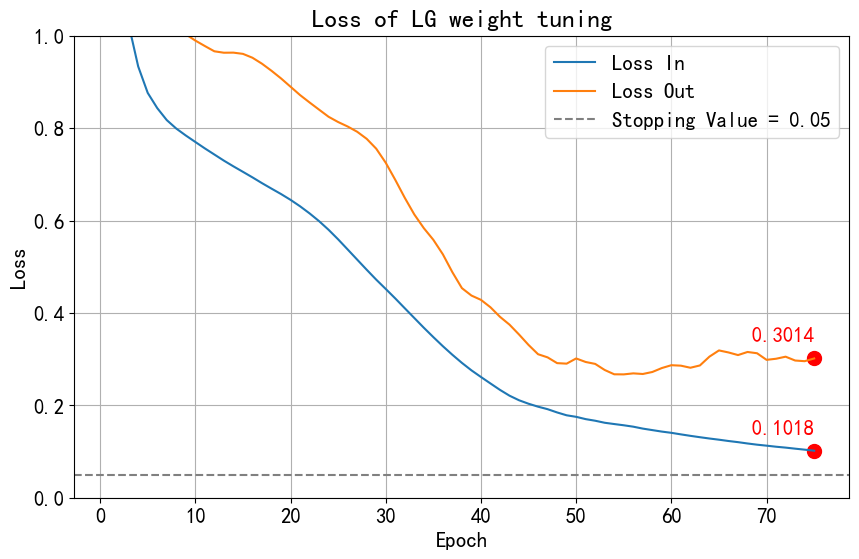

In [102]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.30411389470100403
12822299648.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


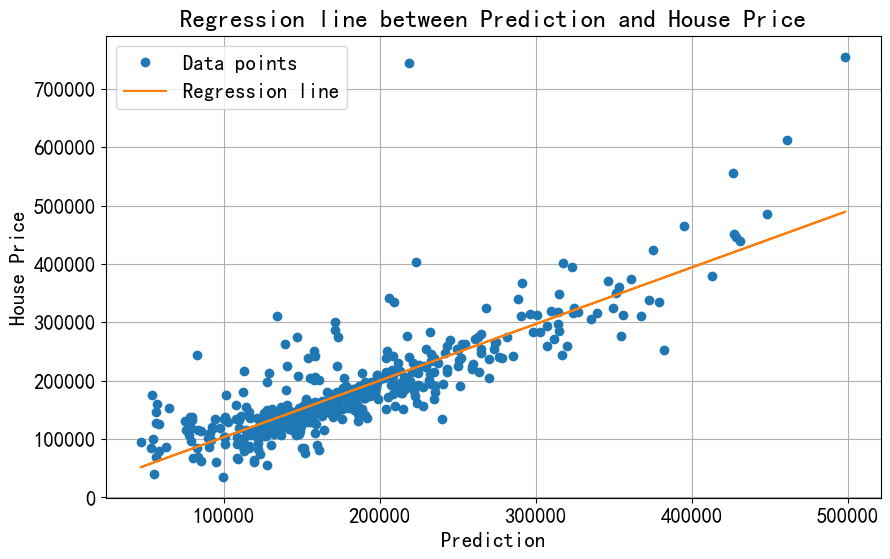

In [103]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [104]:
EB = True
LG = False
UA= False
DO = True
BN = False
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_regulization.append(model_11)

Epoch 1: Loss In 0.6421376466751099, Loss Out 0.30411389470100403, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.5471259951591492, Loss Out 0.4886404871940613, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.5565440058708191, Loss Out 0.6077987551689148, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.4385630488395691, Loss Out 0.548787534236908, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.5039022564888, Loss Out 0.4970521628856659, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.468938946723938, Loss Out 0.42838090658187866, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.4051414430141449, Loss Out 0.4081907868385315, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.47026100754737854, Loss Out 0.4011361002922058, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.47894272208213806, Loss Out 0.38694238662719727, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.4162043035030365, Loss Out 0.3670252859592438, Learni

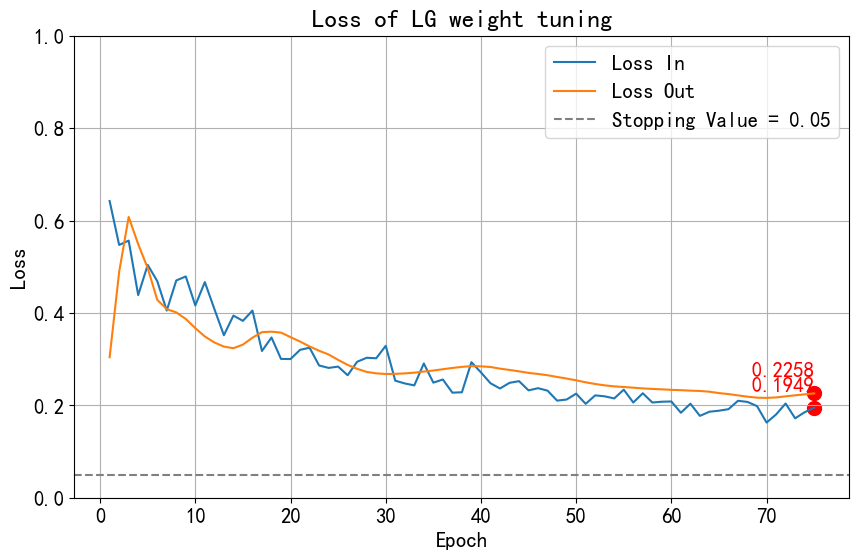

In [105]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.22903701663017273
12126996480.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


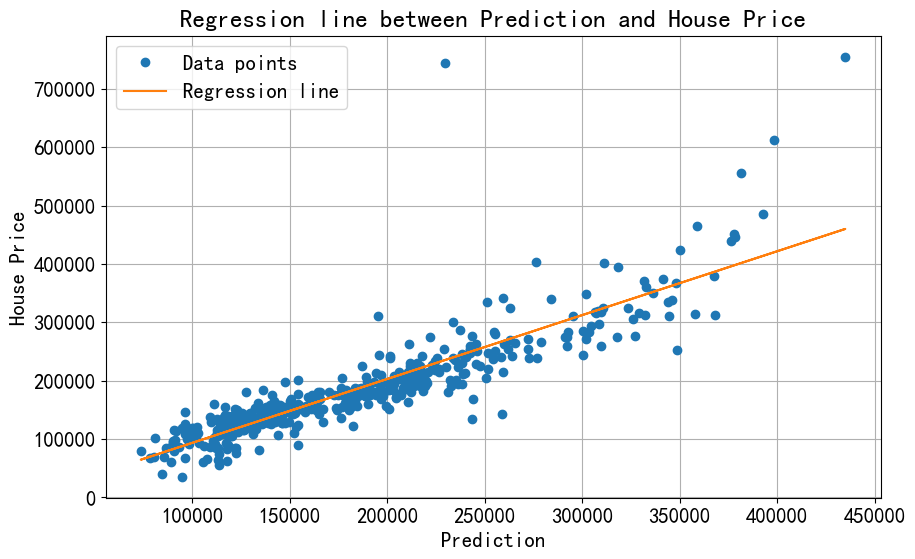

In [106]:
draw_pred_reggsion(model_11,print_error = True)

### 5. weight tuning EB   + regularizing EB DO

In [107]:
models_EBBN_accept = []
models_EBBN_regulization = []

#### train with EB 

In [108]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_accept.append(model_11)



Epoch 1: Loss In 1.9861416816711426, Loss Out 2.307358503341675, Learning Rate 0.001
Epoch 2: Loss In 1.852182149887085, Loss Out 2.176486015319824, Learning Rate 0.001
Epoch 3: Loss In 1.7492300271987915, Loss Out 2.081301212310791, Learning Rate 0.001
Epoch 4: Loss In 1.6674680709838867, Loss Out 1.9975229501724243, Learning Rate 0.001
Epoch 5: Loss In 1.6073306798934937, Loss Out 1.9411717653274536, Learning Rate 0.001
Epoch 6: Loss In 1.5644303560256958, Loss Out 1.911637783050537, Learning Rate 0.001
Epoch 7: Loss In 1.5239918231964111, Loss Out 1.877960205078125, Learning Rate 0.001
Epoch 8: Loss In 1.4837334156036377, Loss Out 1.837769865989685, Learning Rate 0.001
Epoch 9: Loss In 1.4441288709640503, Loss Out 1.7885725498199463, Learning Rate 0.001
Epoch 10: Loss In 1.4060287475585938, Loss Out 1.7357048988342285, Learning Rate 0.001
Epoch 11: Loss In 1.370495080947876, Loss Out 1.6818968057632446, Learning Rate 0.001
Epoch 12: Loss In 1.3403751850128174, Loss Out 1.63376033306

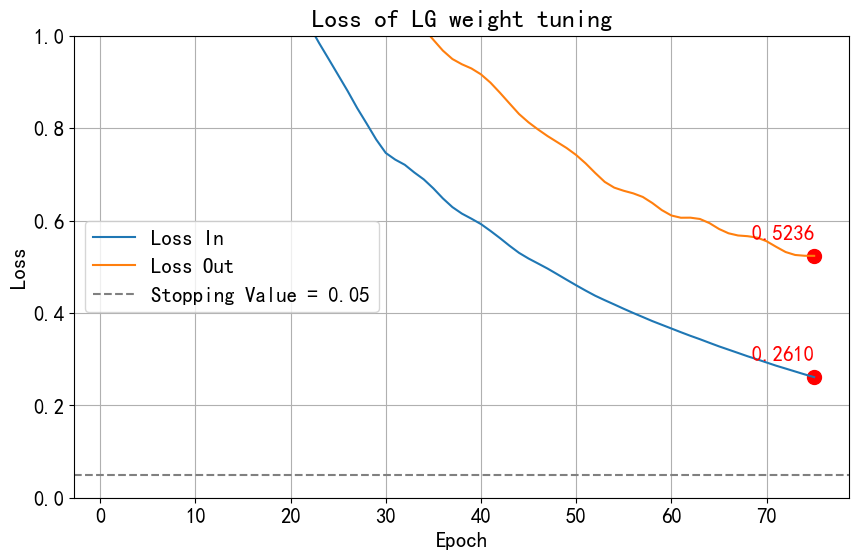

In [109]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.5166227221488953
10200172544.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


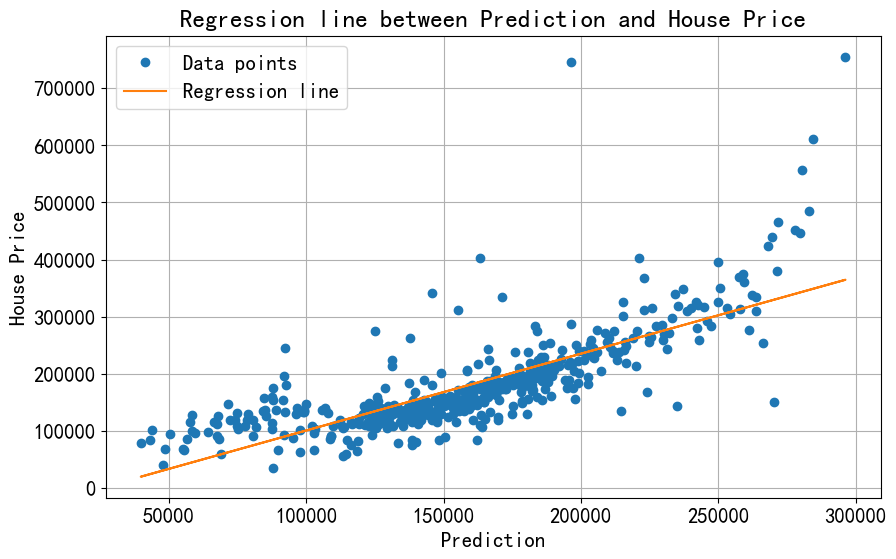

In [110]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [113]:
EB = True
LG = False
UA= False
DO = False
BN = True
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 50

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_regulization.append(model_11)

Epoch 1: Loss In 0.03298895061016083, Loss Out 0.5043054223060608, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.22212207317352295, Loss Out 0.7814711332321167, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.11840333789587021, Loss Out 0.4219760000705719, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.09133898466825485, Loss Out 0.3173542618751526, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.06582712382078171, Loss Out 0.3204265534877777, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.08654137700796127, Loss Out 0.3772296905517578, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.08780194073915482, Loss Out 0.37849104404449463, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.07051976770162582, Loss Out 0.3411061465740204, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.06072121486067772, Loss Out 0.3043966293334961, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.0590682327747345, Loss Out 0.29634559154510

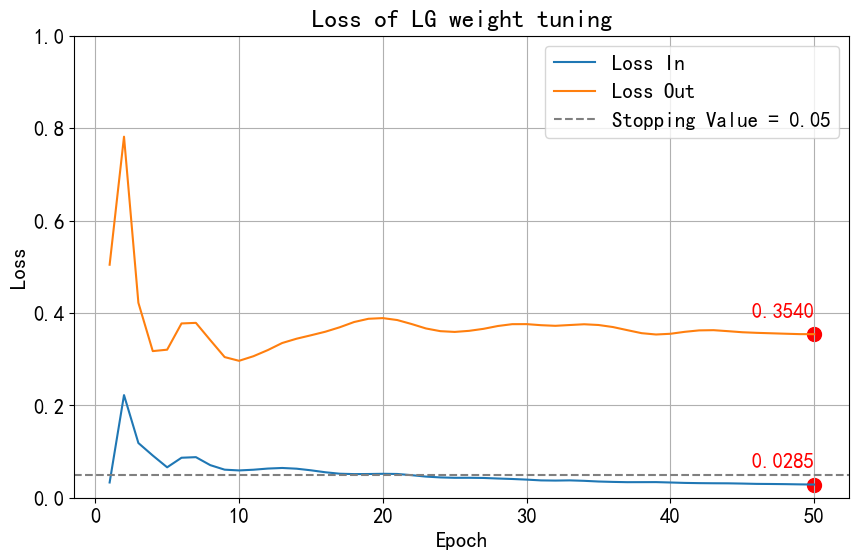

In [114]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.3556588888168335
11841227776.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


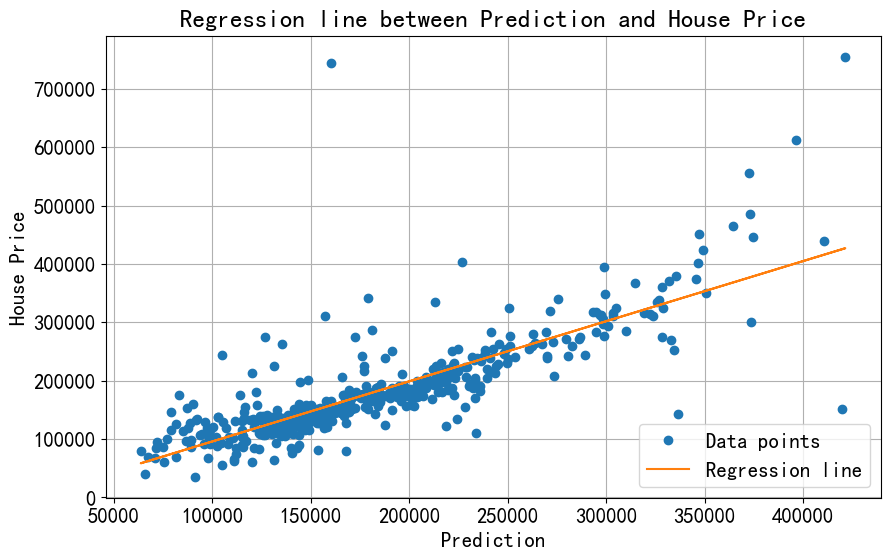

In [115]:
draw_pred_reggsion(model_11,print_error = True)

## Conclusion
#### HW4Update 
#### 1.這次把程式整個大改，把訓練與regulization分開，並且寫成一個訓練的函數，可以選擇是否要EB、LG、UA、DO、BN以及調整訓練模式與regulization模式，雖然最後的code在LG+UA的地方和老師有些差異(老師的LG判定放在迴圈最後，我把LG放在forward後面)，但結果看下來是好的。
#### 2.將訓練與regulization分開後，訓練成本大幅下降，從原本50000步左右變成大約75步，應該是因為加上l2後損失函數圖形變得太複雜，以及沒有l2的話超過75步後容易overfitting導致。一開始把l2丟掉時沒有發現overfitting，等到後來發現model 有訓練模式與評估模式，才發現超級大過擬。
#### 3.小問題，DO layer加上去後拿來做UA的ReduceLROnPlateau就失效了，不管loss 多大lr就是不會變，網路上也找不到相關的議題，可能需要跟老師憶起研究一下。

##### HW3Update 這次加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

##### HW2update 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 6 layer 改成 4layer  214 100 50 11 1 
## initial weight:
#### Xavier 
## Activation:
#### 主要用LeakyRELU
## Loss:
#### MSE ,把 l2 regulization 去掉後從50000步降到75步...
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 6^10-4, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## learn rate scheduler
#### 用ReduceLROnPlateau做UA, 每次變成0.9倍, loss 5輪沒降才會調, 停止值設 6^10-4
## DO
#### 每層被丟掉ˋ的機率都是0.1
## BN
#### 做的是BatchNorm1d，不確定和BatchNorm2d有什麼差別
## Ensembles
#### 下次一定做

